In [1]:
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, NBEATSx, PatchTST, iTransformer, TiDE, TSMixer, TFT
from neuralforecast.losses.pytorch import *
from neuralforecast.tsdataset import TimeSeriesDataset

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

/Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-23 13:28:19,145	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-23 13:28:19,205	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
data_url = 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv'
df = pd.read_csv(data_url, parse_dates=['Datetime'])
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df.head()

,unique_id,ds,y
0,PJM,1998-04-01 01:00:00,22259.0
1,PJM,1998-04-01 02:00:00,21244.0
2,PJM,1998-04-01 03:00:00,20651.0
3,PJM,1998-04-01 04:00:00,20421.0
4,PJM,1998-04-01 05:00:00,20713.0


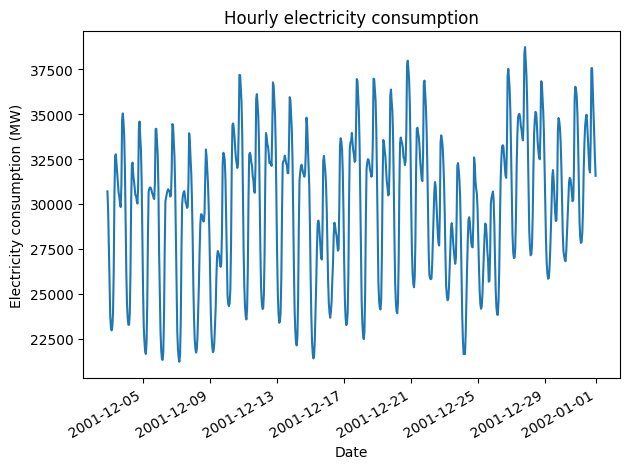

In [4]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-700:], df['y'][-700:])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
Y_train_df = df[:-96]
Y_test_df = df[-96:]

horizon = 96

## PatchTST

In [12]:
model = PatchTST(h=horizon,
                 input_size=2*horizon,
                 patch_len=horizon,
                 stride=horizon,
                 revin=True,
                 hidden_size=32,
                 n_heads=4,
                 scaler_type='robust',
                 loss=MAE(),
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='H'
)

nf.fit(Y_train_df, val_size=horizon)
patchtst_preds = nf.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 75.6 K | train
-----------------------------------------------------------
75.6 K    Trainable params
3         Non-trainable params
75.6 K    Total params
0.302     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, v_num=113, train_loss_step=0.699, train_loss_epoch=0.699, valid_loss=2.27e+3]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, v_num=113, train_loss_step=0.699, train_loss_epoch=0.699, valid_loss=2.27e+3]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


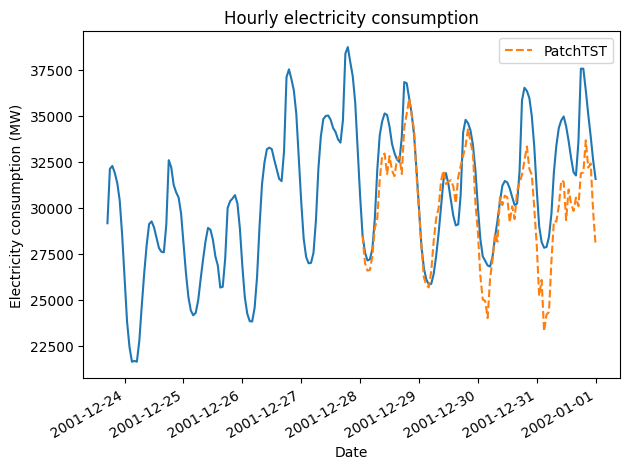

In [14]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-200:], df['y'][-200:])
ax.plot(patchtst_preds['ds'], patchtst_preds['PatchTST'], ls='--', label='PatchTST')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [15]:
Y_test_df['PatchTST'] = patchtst_preds['PatchTST'].values
Y_test_df.head()

,unique_id,ds,y,PatchTST
32800,PJM,2001-12-28 01:00:00,28511.0,28473.951
32801,PJM,2001-12-28 02:00:00,27574.0,26995.598
32802,PJM,2001-12-28 03:00:00,27139.0,26586.680
32803,PJM,2001-12-28 04:00:00,27198.0,26622.463
32804,PJM,2001-12-28 05:00:00,27772.0,27364.033


## iTransformer

In [16]:
model = iTransformer(h=horizon,
                     input_size=2*horizon,
                     n_series=1,
                     hidden_size=128,
                     n_heads=2,
                     e_layers=2,
                     d_layers=1,
                     d_ff=4,
                     factor=1,
                     dropout=0.1,
                     use_norm=True,
                     loss=MSE(),
                     valid_loss=MAE(),
                     early_stop_patience_steps=3,
                     scaler_type='identity',
                     batch_size=32)

nf = NeuralForecast(
    models=[model],
    freq='H'
)

nf.fit(Y_train_df, val_size=horizon)
iTransformer_preds = nf.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MSE                    | 0      | train
1 | valid_loss    | MAE                    | 0      | train
2 | padder        | ConstantPad1d          | 0      | train
3 | scaler        | TemporalNorm           | 0      | train
4 | enc_embedding | DataEmbedding_inverted | 24.7 K | train
5 | encoder       | TransEncoder           | 135 K  | train
6 | projector     | Linear                 | 12.4 K | train
-----------------------------------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.691     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s, v_num=115, train_loss_step=1.03e+7, train_loss_epoch=1.03e+7, valid_loss=2.23e+3]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.10it/s]


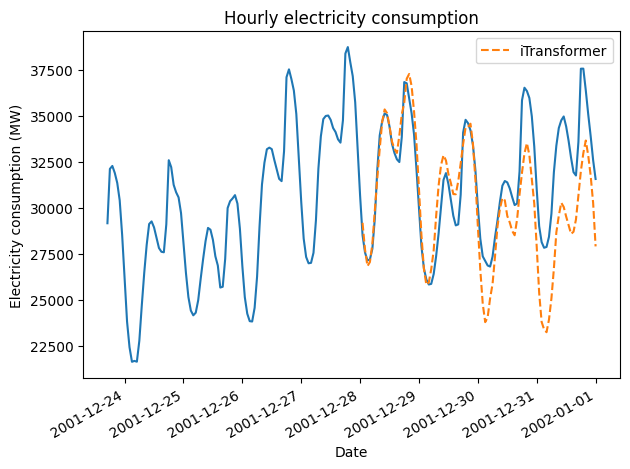

In [17]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-200:], df['y'][-200:])
ax.plot(iTransformer_preds['ds'], iTransformer_preds['iTransformer'], ls='--', label='iTransformer')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
Y_test_df['iTransformer'] = iTransformer_preds['iTransformer'].values

## TiDE

In [19]:
model = TiDE(h=horizon,
             input_size=2*horizon,
             hidden_size=256,
             decoder_output_dim=32,
             temporal_decoder_dim=128,
             dropout=0.0,
             layernorm=True,
             loss=MAE(),
             valid_loss=MAE(),
             early_stop_patience_steps=3,
             scaler_type='identity',
             batch_size=32)

nf = NeuralForecast(
    models=[model],
    freq='H'
)

nf.fit(Y_train_df, val_size=horizon)
tide_preds = nf.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type          | Params | Mode 
-----------------------------------------------------------
0 | loss             | MAE           | 0      | train
1 | valid_loss       | MAE           | 0      | train
2 | padder_train     | ConstantPad1d | 0      | train
3 | scaler           | TemporalNorm  | 0      | train
4 | dense_encoder    | Sequential    | 165 K  | train
5 | dense_decoder    | Sequential    | 1.7 M  | train
6 | temporal_decoder | MLPResidual   | 4.4 K  | train
7 | global_skip      | Linear        | 18.5 K | train
-----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.356     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s, v_num=117, train_loss_step=2.21e+3, train_loss_epoch=2.21e+3, valid_loss=2.12e+3]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.82it/s]


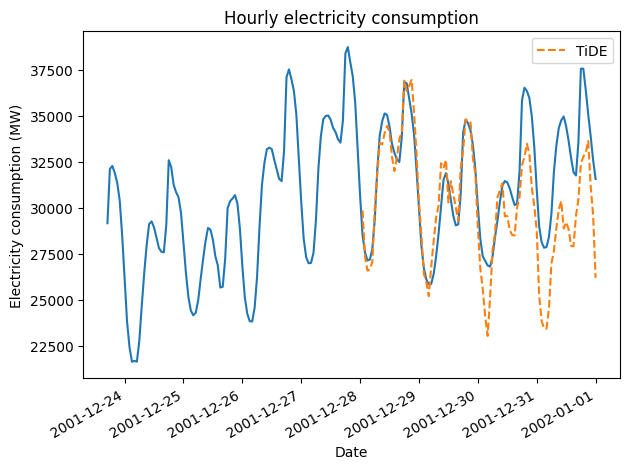

In [20]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-200:], df['y'][-200:])
ax.plot(tide_preds['ds'], tide_preds['TiDE'], ls='--', label='TiDE')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [21]:
Y_test_df['TiDE'] = tide_preds['TiDE'].values
Y_test_df.head()

,unique_id,ds,y,PatchTST,iTransformer,TiDE
32800,PJM,2001-12-28 01:00:00,28511.0,28473.951,29185.865,29860.225
32801,PJM,2001-12-28 02:00:00,27574.0,26995.598,27737.936,27363.131
32802,PJM,2001-12-28 03:00:00,27139.0,26586.680,26830.854,26586.969
32803,PJM,2001-12-28 04:00:00,27198.0,26622.463,27053.404,26653.281
32804,PJM,2001-12-28 05:00:00,27772.0,27364.033,28039.924,27079.291


## TSMixer

In [22]:
model = TSMixer(h=horizon,
                input_size=2*horizon,
                n_series=1, 
                n_block=4,
                ff_dim=4,
                dropout=0,
                revin=True,
                scaler_type='standard',
                max_steps=500,
                early_stop_patience_steps=-1,
                val_check_steps=5,
                learning_rate=1e-3,
                loss=MSE(),
                valid_loss=MAE(),
                batch_size=32
                )

nf = NeuralForecast(
    models=[model],
    freq='H'
)

nf.fit(Y_train_df, val_size=horizon)
tsmixer_preds = nf.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | loss          | MSE                      | 0      | train
1 | valid_loss    | MAE                      | 0      | train
2 | padder        | ConstantPad1d            | 0      | train
3 | scaler        | TemporalNorm             | 0      | train
4 | norm          | ReversibleInstanceNorm1d | 2      | train
5 | mixing_layers | Sequential               | 151 K  | train
6 | out           | Linear                   | 18.5 K | train
-------------------------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
0.680     Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s, v_num=119, train_loss_step=0.337, train_loss_epoch=0.337, valid_loss=0.722]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s, v_num=119, train_loss_step=0.337, train_loss_epoch=0.337, valid_loss=0.722]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.35it/s]


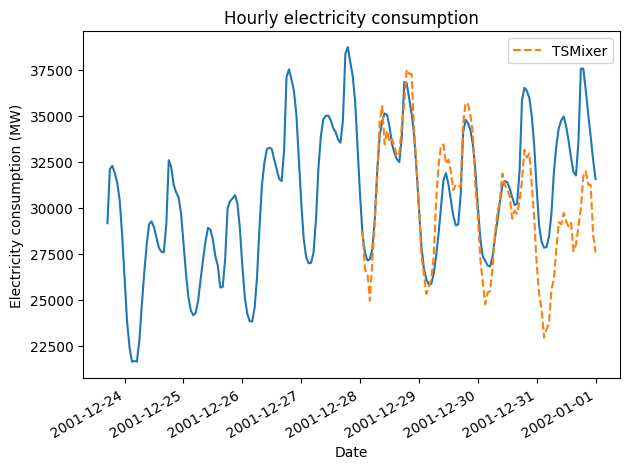

In [23]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-200:], df['y'][-200:])
ax.plot(tsmixer_preds['ds'], tsmixer_preds['TSMixer'], ls='--', label='TSMixer')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [24]:
Y_test_df['TSMixer'] = tsmixer_preds['TSMixer'].values
Y_test_df.head()

,unique_id,ds,y,PatchTST,iTransformer,TiDE,TSMixer
32800,PJM,2001-12-28 01:00:00,28511.0,28473.951,29185.865,29860.225,28724.582
32801,PJM,2001-12-28 02:00:00,27574.0,26995.598,27737.936,27363.131,26658.812
32802,PJM,2001-12-28 03:00:00,27139.0,26586.680,26830.854,26586.969,26436.350
32803,PJM,2001-12-28 04:00:00,27198.0,26622.463,27053.404,26653.281,24952.809
32804,PJM,2001-12-28 05:00:00,27772.0,27364.033,28039.924,27079.291,27153.617


In [25]:
evaluation = evaluate(df=Y_test_df, metrics=[mae, smape])
evaluation

,unique_id,metric,PatchTST,iTransformer,TiDE,TSMixer
0,PJM,mae,1822.021,1914.072,1909.475,2078.259
1,PJM,smape,0.029,0.032,0.031,0.034
